### **This Notebook Performs a Parameters Search on Every Possible Cleaning and Model Parameter.**

Lets test different spectral cleaning parameters by building a model pipeline.

Import Libraries

In [37]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, GroupKFold, cross_val_score, GridSearchCV
from Spectra_Preparation_Functions import *
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

Read the spectral data

In [2]:
#df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")
# df = pd.read_csv("../../data/raw_df_outliers_removed.csv")
df = pd.read_csv("../../data/400-1800_with_raw_scaled_surface_pagerank.csv")

In [3]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,PageRank
0,201210-1-00,293,400.22778,1765.6628,201210-1,Normal,0.610024
1,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,0.610024
2,201210-1-00,295,401.59454,1769.0302,201210-1,Normal,0.610024
3,201210-1-00,296,402.27789,1756.4220,201210-1,Normal,0.610024
4,201210-1-00,297,402.96127,1758.8690,201210-1,Normal,0.610024
...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia,1.201164
6239201,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia,1.201164
6239202,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia,1.201164
6239203,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia,1.201164


**Cleaning Parameters**

These were based on the parameter search

In [4]:
# Decide which cleaning steps to implement
pagerank_cutoff = 0.824056911
despike_ma = 92
despike_threshold = 3.5
lam = 10 ** 11
p = 0.1

Implement the cleaning

In [5]:
clean_df = df[df['PageRank'] > pagerank_cutoff]

In [15]:
len(clean_df.groupby('SpecID'))

1939

In [13]:
clean_df.groupby('Status')['SpecID'].nunique()

Status
Hyperglycemia    542
Hypoglycemia     715
Normal           682
Name: SpecID, dtype: int64

In [6]:
clean_df['SpecID'].unique()

array(['201210-1-02', '201210-1-03', '201210-1-07', ..., '210526-3-49',
       '210526-3-08', '210526-3-09'], dtype=object)

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_22260\4061213677.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Despiked_Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x, ma=despike_ma, threshold=despike_threshold))
C:\Users\FX 8320\AppData\Local\Temp\ipykernel_22260\4061213677.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline'] = sample.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p

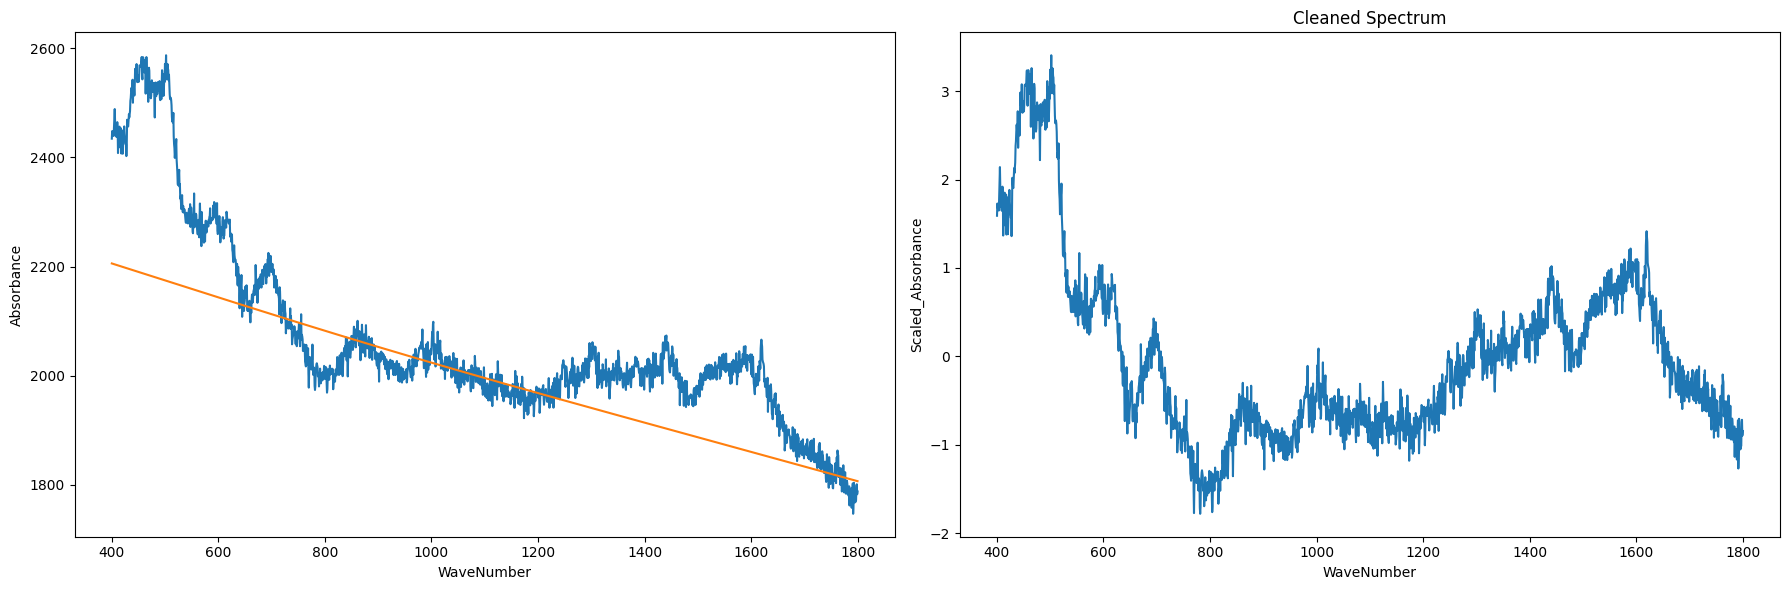

In [8]:
# Selecting the sample from the dataframe based on 'SpecID'
sample = clean_df[clean_df['SpecID'] == "201210-1-07"]

# Creating a figure with 2 subplots in one row
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sample['Despiked_Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x, ma=despike_ma, threshold=despike_threshold))
sample['Baseline'] = sample.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample, ax=axes[0])
sns.lineplot(x="WaveNumber", y="Baseline", data=sample, ax=axes[0])
axes[1].set_title('Absorbance with Baseline')

# Plot 3: Baseline Corrected Absorbance and Smoothed
sample['Baseline_Corrected_Absorbance'] = sample['Despiked_Absorbance'] - sample['Baseline']
sample['Scaled_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: svn_normalise(x))
sns.lineplot(x="WaveNumber", y="Scaled_Absorbance", data=sample, ax=axes[1])
axes[1].set_title('Cleaned Spectrum')

# Display the plots
plt.tight_layout()  # Adjust the layout to make sure there's no overlap
plt.show()

In [9]:
clean_df['Despiked_Absorbance'] = clean_df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x, ma=despike_ma, threshold=despike_threshold))
clean_df['Baseline'] = clean_df.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))
clean_df['Baseline_Corrected_Absorbance'] = clean_df['Despiked_Absorbance'] - clean_df['Baseline']
clean_df['Scaled_Absorbance'] = clean_df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: svn_normalise(x))

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_22260\3404651976.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['Despiked_Absorbance'] = clean_df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x, ma=despike_ma, threshold=despike_threshold))
C:\Users\FX 8320\AppData\Local\Temp\ipykernel_22260\3404651976.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['Baseline'] = clean_df.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=

In [10]:
clean_df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,PageRank,Despiked_Absorbance,Baseline,Baseline_Corrected_Absorbance,Scaled_Absorbance
4098,201210-1-02,293,400.22778,2182.6694,201210-1,Normal,0.961147,2182.6694,2047.983637,134.685763,0.387154
4099,201210-1-02,294,400.91116,2149.6565,201210-1,Normal,0.961147,2149.6565,2048.003637,101.652863,0.143959
4100,201210-1-02,295,401.59454,2146.0227,201210-1,Normal,0.961147,2146.0227,2048.023636,97.999064,0.117058
4101,201210-1-02,296,402.27789,2159.3459,201210-1,Normal,0.961147,2159.3459,2048.043636,111.302264,0.215000
4102,201210-1-02,297,402.96127,2167.2910,201210-1,Normal,0.961147,2167.2910,2048.063635,119.227365,0.273346
...,...,...,...,...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia,1.201164,1617.3926,1770.249312,-152.856712,-2.302332
6239201,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia,1.201164,1633.0911,1769.946779,-136.855679,-2.165301
6239202,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia,1.201164,1633.3076,1769.644245,-136.336645,-2.160856
6239203,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia,1.201164,1641.8665,1769.341712,-127.475212,-2.084968


In [18]:
wavelength_df = prepare_wavelength_df(clean_df, 'Scaled_Absorbance')
wavelength_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-02,0.387154,0.143959,0.117058,0.215000,0.273346,0.226781,0.113781,0.029284,0.092672,0.061608,...,-1.318869,-1.224532,-1.171024,-1.295672,-1.318849,-1.180542,-1.333518,-1.355698,201210-1,Normal
201210-1-03,-0.322233,-0.377119,-0.406082,-0.362514,-0.284758,-0.255112,-0.285655,-0.236506,-0.305067,-0.411116,...,-1.650620,-1.536285,-1.614261,-1.582751,-1.595934,-1.554886,-1.475848,-1.616807,201210-1,Normal
201210-1-07,1.590973,1.729138,1.678946,1.716794,1.719294,1.650259,1.792391,1.972000,2.141552,1.896857,...,-1.010676,-1.051011,-1.020404,-1.013684,-0.744180,-0.718906,-0.897704,-0.844931,201210-1,Normal
201210-1-09,1.840965,1.828747,1.789689,1.859896,1.951399,1.976493,1.969735,1.866808,1.681478,1.714805,...,-0.481731,-0.588972,-0.636404,-0.766483,-0.517136,-0.559250,-0.367209,-0.763921,201210-1,Normal
201210-1-10,1.147777,1.255007,0.853108,0.916829,1.121588,0.965771,0.850365,1.085054,0.643614,0.581263,...,-0.778024,-1.015345,-1.074649,-1.074681,-0.874090,-0.919638,-0.980606,-0.778525,201210-1,Normal


>#### **Evaluate Model Performance**

In [27]:
def evaluate_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)
    
    # Getting cross-validation scores
    scores = cross_validate(et, X, y, groups=groups, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1)

    # Displaying the results
    print(f"{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{et.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{et.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{et.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

In [28]:
def evaluate_random_forest(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    rf = RandomForestClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)
    
    # Getting cross-validation scores
    scores = cross_validate(rf, X, y, groups=groups, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1)

    # Displaying the results
    print(f"{rf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{rf.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{rf.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{rf.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

In [29]:
def evaluate_svm(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    svc = SVC(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)
    
    # Getting cross-validation scores
    scores = cross_validate(svc, X, y, groups=groups, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1)

    # Displaying the results
    print(f"{svc.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{svc.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{svc.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{svc.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

In [30]:
evaluate_extra_trees(wavelength_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.6735 +/- 0.1165
ExtraTreesClassifier Cross-Validation Precision: 0.6606 +/- 0.1313
ExtraTreesClassifier Cross-Validation Recall: 0.6668 +/- 0.1552
ExtraTreesClassifier Cross-Validation F1-Score: 0.6356 +/- 0.1409


In [31]:
evaluate_random_forest(wavelength_df)

RandomForestClassifier Cross-Validation Accuracy: 0.6847 +/- 0.1134
RandomForestClassifier Cross-Validation Precision: 0.6589 +/- 0.1510
RandomForestClassifier Cross-Validation Recall: 0.6718 +/- 0.1608
RandomForestClassifier Cross-Validation F1-Score: 0.6402 +/- 0.1518


In [32]:
evaluate_svm(wavelength_df)

SVC Cross-Validation Accuracy: 0.6369 +/- 0.1653
SVC Cross-Validation Precision: 0.6238 +/- 0.1882
SVC Cross-Validation Recall: 0.6286 +/- 0.2051
SVC Cross-Validation F1-Score: 0.5929 +/- 0.1931


>#### **Perform Grid Search to Tune Model Parameters**

In [77]:
def extra_trees_nested_cross_validation(df, param_grid):
    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for the outer CV loop
    outer_cv = GroupKFold(n_splits=10)

    # Set up the inner CV loop for parameter tuning
    inner_cv = GroupKFold(n_splits=5)
    
    # Setting up GridSearchCV for finding the best model using the inner loop
    grid_search = GridSearchCV(estimator=et, param_grid=param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1)

    # Using the outer CV loop to evaluate the best models found in the inner CV
    scores = cross_validate(grid_search, X, y, groups=groups, cv=outer_cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1, params={'groups': groups})  # The params ensure the inner fold is based on the groups

    # Displaying the results
    print(f"{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{et.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{et.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{et.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

In [78]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt', 'log2']
}
extra_trees_nested_cross_validation(wavelength_df, param_grid)

ExtraTreesClassifier Cross-Validation Accuracy: 0.6749 +/- 0.1175
ExtraTreesClassifier Cross-Validation Precision: 0.6651 +/- 0.1378
ExtraTreesClassifier Cross-Validation Recall: 0.6656 +/- 0.1551
ExtraTreesClassifier Cross-Validation F1-Score: 0.6359 +/- 0.1436


In [81]:
def random_forest_nested_cross_validation(df, param_grid):
    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Random Forest classifier
    rf = RandomForestClassifier(random_state=1234)
    
    # Using GroupKFold for the outer CV loop
    outer_cv = GroupKFold(n_splits=10)

    # Set up the inner CV loop for parameter tuning
    inner_cv = GroupKFold(n_splits=5)
    
    # Setting up GridSearchCV for finding the best model using the inner loop
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1)

    # Using the outer CV loop to evaluate the best models found in the inner CV
    scores = cross_validate(grid_search, X, y, groups=groups, cv=outer_cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1, params={'groups': groups})

    # Displaying the results
    print(f"{rf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{rf.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{rf.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{rf.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

In [82]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt', 'log2']
}

random_forest_nested_cross_validation(wavelength_df, param_grid)

RandomForestClassifier Cross-Validation Accuracy: 0.6712 +/- 0.1327
RandomForestClassifier Cross-Validation Precision: 0.6605 +/- 0.1544
RandomForestClassifier Cross-Validation Recall: 0.6653 +/- 0.1710
RandomForestClassifier Cross-Validation F1-Score: 0.6350 +/- 0.1597


In [83]:
def svc_nested_cross_validation(df, param_grid):
    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Support Vector Classifier
    svc = SVC(random_state=1234)

    # Using GroupKFold for the outer CV loop
    outer_cv = GroupKFold(n_splits=10)

    # Set up the inner CV loop for parameter tuning
    inner_cv = GroupKFold(n_splits=5)
    
    # Setting up GridSearchCV for finding the best model using the inner loop
    grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1)

    # Using the outer CV loop to evaluate the best models found in the inner CV
    scores = cross_validate(grid_search, X, y, groups=groups, cv=outer_cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1, params={'groups': groups})  # The params ensure the inner fold is based on the groups

    # Displaying the results
    print(f"{svc.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{svc.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{svc.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{svc.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

In [84]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [3, 5],  # only used for 'poly' kernel
}
svc_nested_cross_validation(wavelength_df, param_grid)

SVC Cross-Validation Accuracy: 0.6333 +/- 0.1648
SVC Cross-Validation Precision: 0.6260 +/- 0.1701
SVC Cross-Validation Recall: 0.6235 +/- 0.1972
SVC Cross-Validation F1-Score: 0.5996 +/- 0.1828
